<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Мы имеем исторические данные о заказах такси в аэропортах.
Нам необходимо спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.


- Значение метрики **RMSE** на тестовой выборке должно быть не больше **48**
- Количество заказов находится в столбце **'num_orders' (от англ. number of orders, «число заказов»)**

# Подготовка

In [1]:
#импортируем нужные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import os

!pip install plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2
import requests
!pip install cufflinks
import cufflinks as cf
cf.go_offline()
cf.set_config_file(world_readable=True, theme='pearl', offline=True)



#стат блок
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

!pip install prophet
from prophet import Prophet

#настройки
pd.set_option("display.max_rows", 10000)
pd.set_option('max_colwidth', 10000)
pd.set_option('display.width', 500)
pd.set_option("display.float_format", "{:,.2f}".format)
sns.set(style="whitegrid", palette="Pastel1")


import warnings
warnings.filterwarnings('ignore')


from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import (
                ElasticNet,
                Ridge,
                Lasso
)
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import (
                Pipeline, 
                make_pipeline
)

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import ( 
                TimeSeriesSplit,
                train_test_split,
                GridSearchCV,
                cross_val_score
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error
)


RANDOM_STATE = 42

C:\Users\390\anaconda3\envs\ds_practicum_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
try:
    taxi = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
except FileNotFoundError:
    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
#оставим копию на всякий случай
try:
    df = pd.read_csv('taxi.csv')
except FileNotFoundError:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [4]:
taxi.columns

Index(['num_orders'], dtype='object')

In [5]:
#функция для быстрого просмотра данных
def information(df: 'DataFrame', name: 'str') -> None:
    print('*'*30,name,'*'*30)
    print()
    display(df.head(3))
    print('-'*25,'INFO','-'*25)
    print()
    display(df.info())
    print()
    print('-'*10,'NAN','-'*10)
    print()
    display(df.isna().sum())
    display(pd.DataFrame(round(df.isna().mean()*100,1)).sort_values(by=0, ascending=False).style.background_gradient('coolwarm'))
    print()
    print('-'*5,'DESCRIBE','-'*5)
    display(df.describe())
    print()
    print('-'*5,'DUPLICATED','-'*5)
    display(df.duplicated().sum())
    print()
    print('-'*25,'UNIQUE VALUES','-'*25)
    for column in df.columns:
        display(column)
        display(len(df[column].unique()))
        print('+'*25)
    print("-"*100)

In [6]:
information(taxi, 'Такси')

****************************** Такси ******************************



num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28

------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None


---------- NAN ----------



num_orders    0
dtype: int64


----- DESCRIBE -----


num_orders
count   26,496.00
mean        14.07
std          9.21
min          0.00
25%          8.00
50%         13.00
75%         19.00
max        119.00


----- DUPLICATED -----


26415


------------------------- UNIQUE VALUES -------------------------


'num_orders'

81

+++++++++++++++++++++++++
----------------------------------------------------------------------------------------------------


### Вывод:

Итак, данные выгружены:
- Выполнили чтение файла с разпознованием даты, дату поставили в индекс
- Мы имеем **26496** наблюдений
- В **datetime** имеем интервалы в **10 минут**
- Максимальное количество заказов **119** скорее всего выбросы, нужно исследовать наш таргет


# Анализ

Проверим, все ли индексы у нас уникальны.

In [7]:
print('Все индексы уникальны -', taxi.index.is_unique)

Все индексы уникальны - True


In [8]:
taxi.shape[0]

26496

Проверим последовательность индексов.

In [9]:
print('Индексы отсортированы в порядке возрастания -', taxi.index.is_monotonic)

Индексы отсортированы в порядке возрастания - True


In [10]:
#делаем ресэмплинг по 1 часу
taxi = taxi.resample('1H').sum()

In [11]:
taxi.shape[0]

4416

In [12]:
display(taxi.index.max())
display(taxi.index.min())

Timestamp('2018-08-31 23:00:00', freq='H')

Timestamp('2018-03-01 00:00:00', freq='H')

Наблюдения у нас с **1 марта 2018 года по 31 августа 2018 года**

In [13]:
taxi.index.max() - taxi.index.min()

Timedelta('183 days 23:00:00')

Всего **183** дня наблюдений, наблюдения производились с 00:00:00 по  23:00:00

**Посмотрим интерактивный график заказов по нашему датасету**

In [14]:
#функция для просмотра интерактивного графика по датасету
def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
%pylab inline    
 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [15]:
plotly_df(taxi, title='Число заказов')
show()

Посмотрим на распределение нашего таргета:

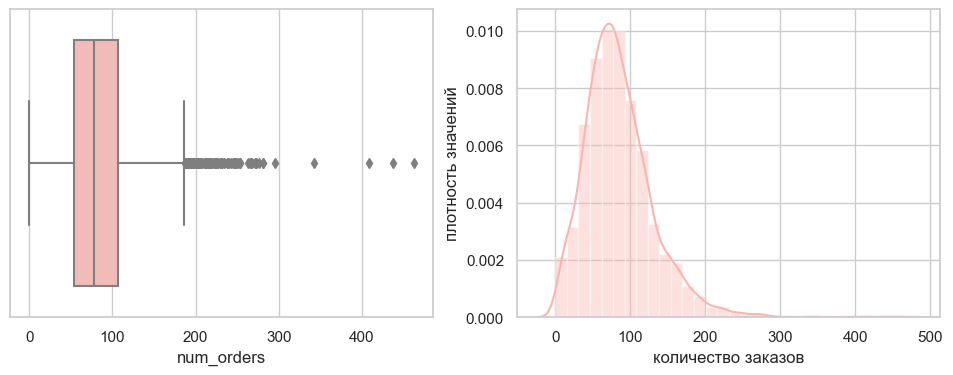

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(taxi['num_orders'], ax=axs[0])
sns.distplot(taxi['num_orders'], ax=axs[1], bins=30, rug=False)
plt.ylabel('плотность значений')
plt.xlabel('количество заказов');

In [17]:
taxi['num_orders'].quantile([0.0, 0.01, 0.02, 0.05, 0.1, 0.25, .5, .65, .75, .85, .93, .97, .99, 1]).transpose()

0.00     0.00
0.01     7.00
0.02    11.30
0.05    21.00
0.10    34.00
0.25    54.00
0.50    78.00
0.65    94.00
0.75   107.00
0.85   126.00
0.93   156.00
0.97   184.00
0.99   223.00
1.00   462.00
Name: num_orders, dtype: float64

По распределению значений можем наблюдать выбросы примерно после **184** заказов, но так как подробностей нам не узнать, будем исследовать данные. Видим, что частота значений начиная от **184** и заканчивая **290** заказами имеет плюс минус плотное распределение. Посмторим на цифры выше **300** особенно даты в эти заказы.

In [18]:
taxi.query('num_orders >=300')

num_orders
datetime                       
2018-08-13 02:00:00         437
2018-08-20 02:00:00         462
2018-08-27 02:00:00         408
2018-08-30 17:00:00         342

Интересно, что выбросы свыше **300** заказов были в основном в августе по понедельникам в **02:00**, вероятнее всего возвращающиеся с отпусков, так как в ночь с вскр на пнд, и один из дней четверг **30 августа** в час пик в **17:00**  это скорее всего суматоха родителей перед началом учебного года у школьников. Исходя иза этих данных можно сделать выводы, какие признаки создавать для модели: можно взять **день недели** и **время суток**

### Посмотрим на общую картину нашего временного ряда

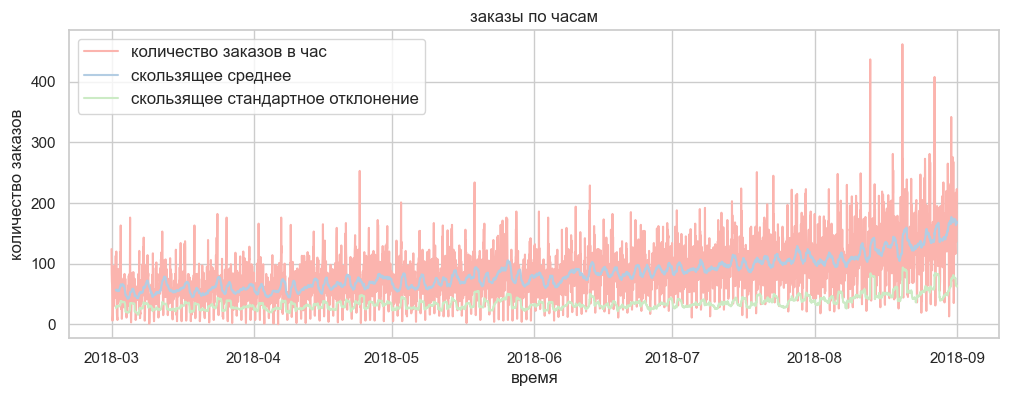

In [19]:
# построим график временного ряда
plt.figure(figsize=(12, 4))
plt.plot(taxi, label = 'количество заказов в час')
plt.plot(taxi.rolling(24).mean(), label = 'скользящее среднее')
plt.plot(taxi.rolling(24).std(), label = 'скользящее стандартное отклонение')

plt.legend(title='', loc='upper left', fontsize=12)
plt.xlabel('время')
plt.ylabel('количество заказов')
plt.title('заказы по часам')
plt.show;

- Как видим тренд на повышение идет с начала **апреля** и до конца наблюдений
- Видны переодичные всплески по месяцам, можно увидеть что в конце **апреля** есть большой всплеск, в **мае**, а также большее количество всплесков наблюдаем в **августе**

### Визуализируем данные по составляющим. Проанализируем их по последнему месяцу наблюдений - август 2018.

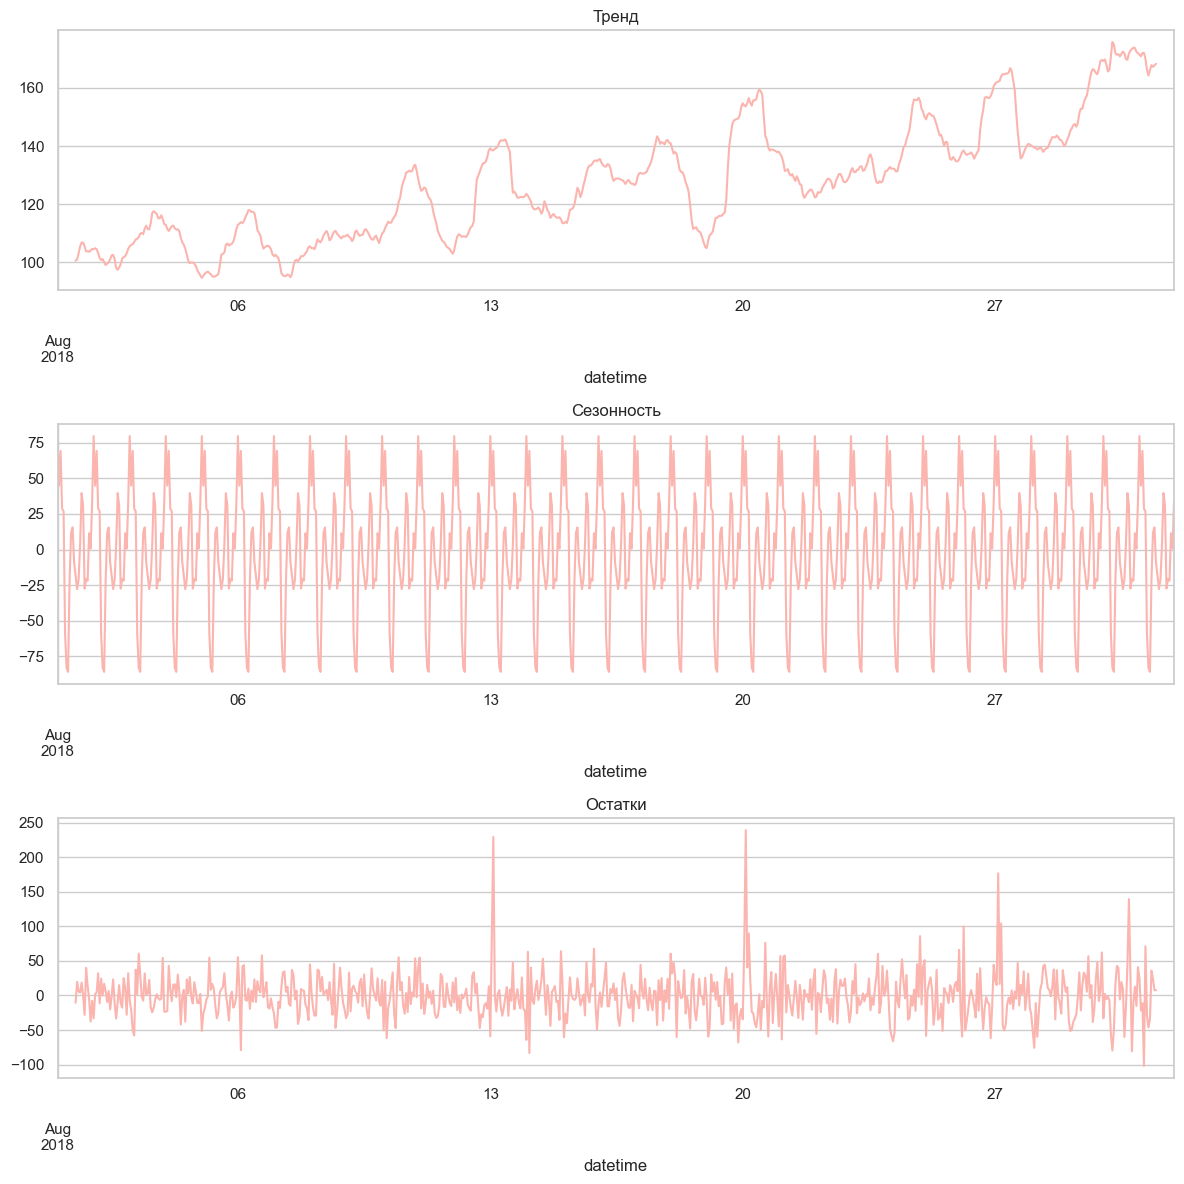

In [20]:
decomposed = seasonal_decompose(taxi['2018-08-01':'2018-08-31'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Остатки')
plt.tight_layout()

- Тренд имеет рост на протяжении всего месяца, очень хорошо видно наши пики - **13, 20, 27 и 30 августа**
- Чтобы понять как влияет сезонность нужно сделать визуализацию автокорреляции
- Остатки тоже имеют переодические всплески как раз в те же дни что и у тренда

### Посмотрим на сезонность и тренд по всему датасету 

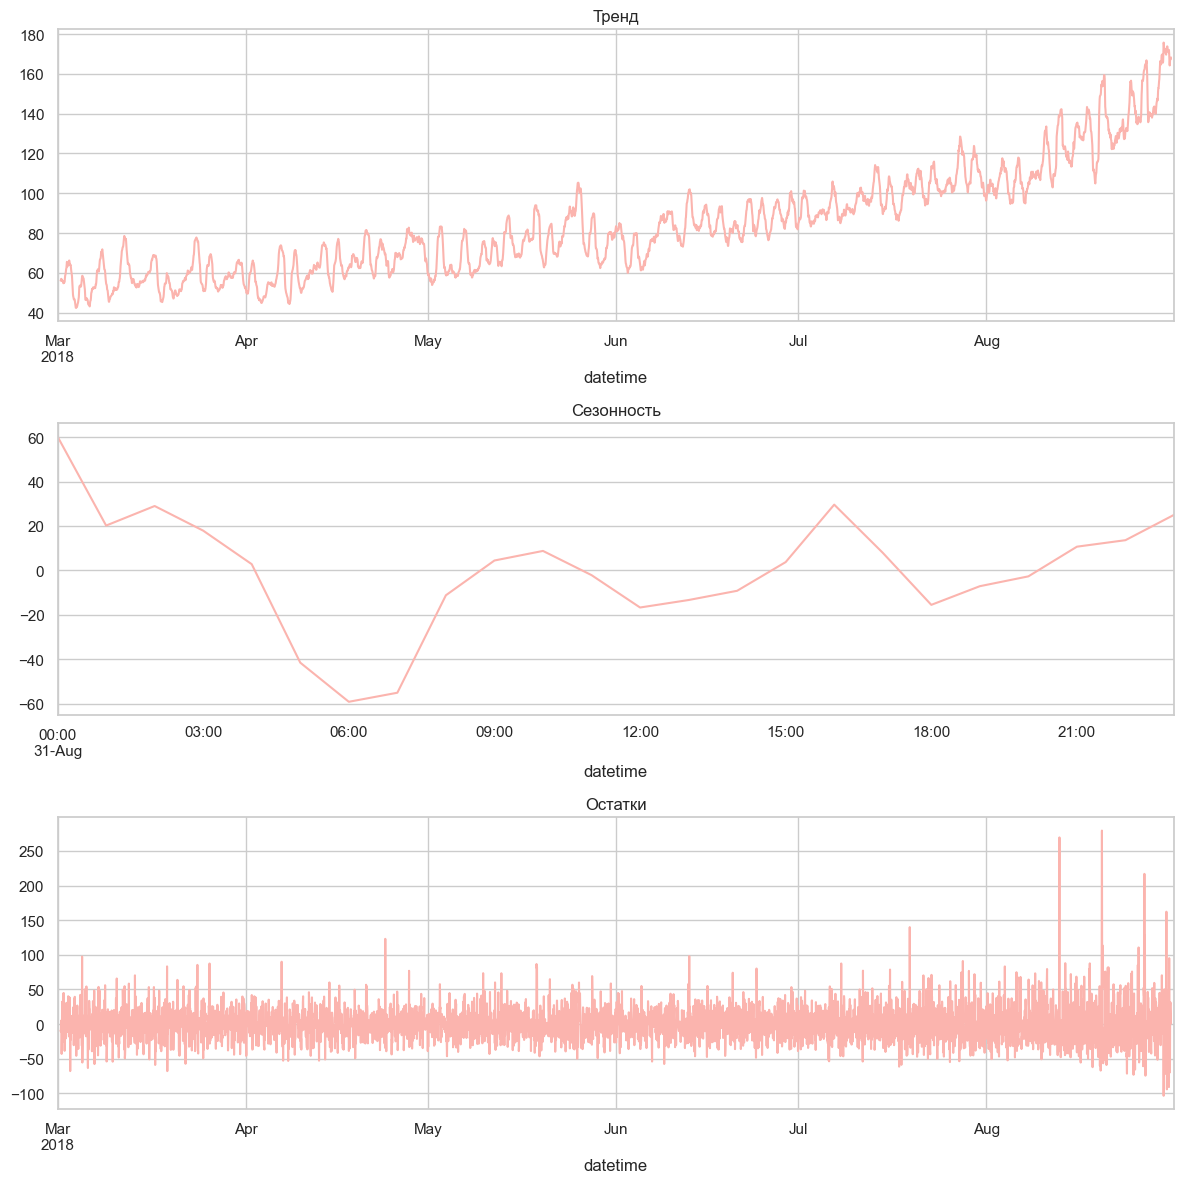

In [21]:
decomposed = seasonal_decompose(taxi)
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

#посмотрим на дневную сезонность
decomposed.seasonal.tail(24).plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Остатки')
plt.tight_layout()

### Проведем стат тест **Dickey-Fuller** (Дики-Фуллера) на стационарность ряда и визуализируем наши данные в автокорреляции по часам

**Сформулируем гипотезы:**

- **H0:** Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.

- **H1:** Временной ряд является стационарным.

- Установим **α = 0.01 (1%)**



Критерий Дики-Фуллера: p=0.028940
H0 подтвердилась, временной ряд имеет единичные корни, ряд не стационарен


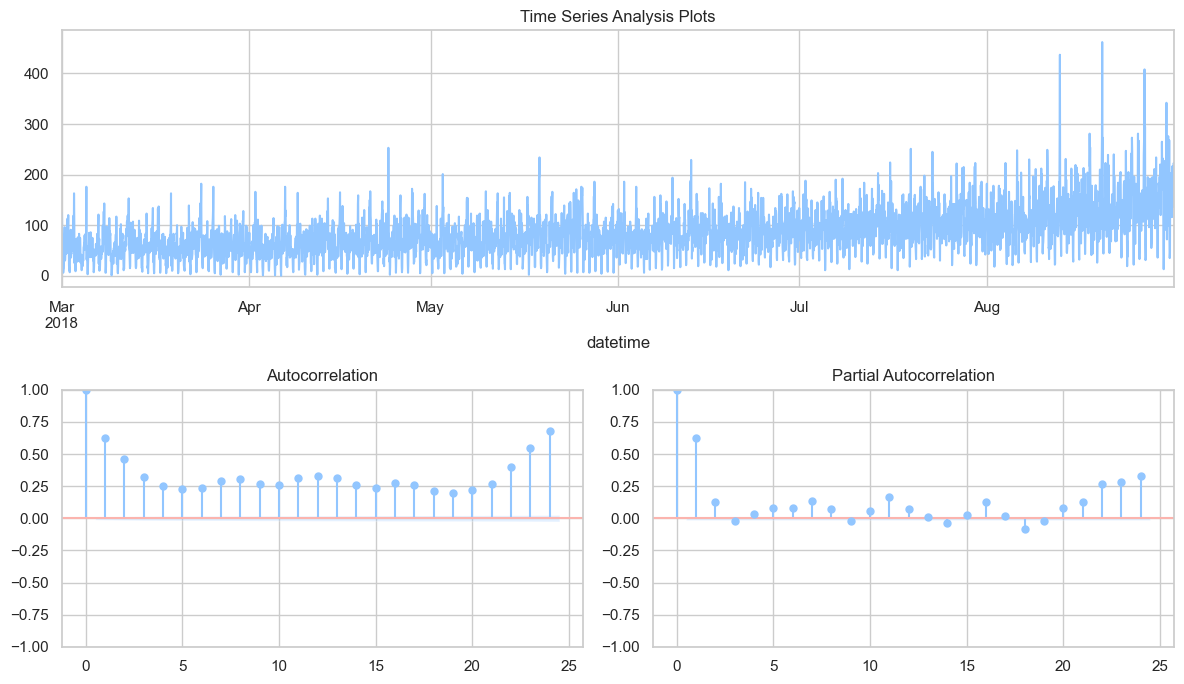

In [22]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context("seaborn-pastel"):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        
        α = 0.01

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        if sm.tsa.stattools.adfuller(y)[1] > 0.01:
            print("H0 подтвердилась, временной ряд имеет единичные корни, ряд не стационарен")
        else:
            print("отвергаем H0, временной ряд не имеет единичных корней , ряд стационарен") 

        plt.tight_layout()
    return 

tsplot(taxi['num_orders'], lags=24)

Как мы можем наблюдать, при установке значимости **α = 0.01 (1%)** у нас ряд **не стационарен**, однако, если установить уровень значимости **α = 0.05 (5%)** ряд будет **стационарным**.

Но так как мы всегда полагаемся на данные и наши исследования (мы наблюдаем рост заказов в тренде, причем зависимость не линейная а скорее квадратичная, плюс наблюдается наличие сезонности, отчетливо видна **дневная** сезонность), устанавливаем значение **α** строже, так как понимая нашу задачу прогнозирования заказов, этот фактор имеет очень важную составляющую. Прогнозировать на нестационарном ряду сложнее, чем на стационарном. Иначе говоря, нам предстоит строить прогнозирование сравнивая исходный датасет. 

По графику автокорреляции можем наблюдать пики начиная с **00:00 часов и заканчивая 3 часами ночи**, далее **с 22 часов и до 00:00** так же.


In [23]:
taxi.shape[0]

4416

### Создадим признаки с помощью Prophet

In [24]:
predictions = 24*4

train_df = taxi[:-predictions]
train_df.reset_index(inplace=True)
train_df.columns = ['ds', 'y']
taxi.columns = ['y']
train_df.tail()

# Python
m = Prophet(changepoint_prior_scale=0.10, seasonality_prior_scale=10.00, holidays_prior_scale=0.01,
            seasonality_mode= 'additive')
m.fit(train_df);

future = m.make_future_dataframe(periods=predictions, freq='1H')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

15:52:44 - cmdstanpy - INFO - Chain [1] start processing
15:52:45 - cmdstanpy - INFO - Chain [1] done processing


ds   yhat  yhat_lower  yhat_upper
4411 2018-08-31 19:00:00 141.85      107.34      177.58
4412 2018-08-31 20:00:00 148.66      112.96      180.87
4413 2018-08-31 21:00:00 163.98      134.41      199.02
4414 2018-08-31 22:00:00 177.79      145.51      211.64
4415 2018-08-31 23:00:00 185.04      149.35      218.76

In [25]:
forecast.shape[0]

4416

In [26]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, daily, daily_lower, daily_upper, weekly, weekly_lower, weekly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


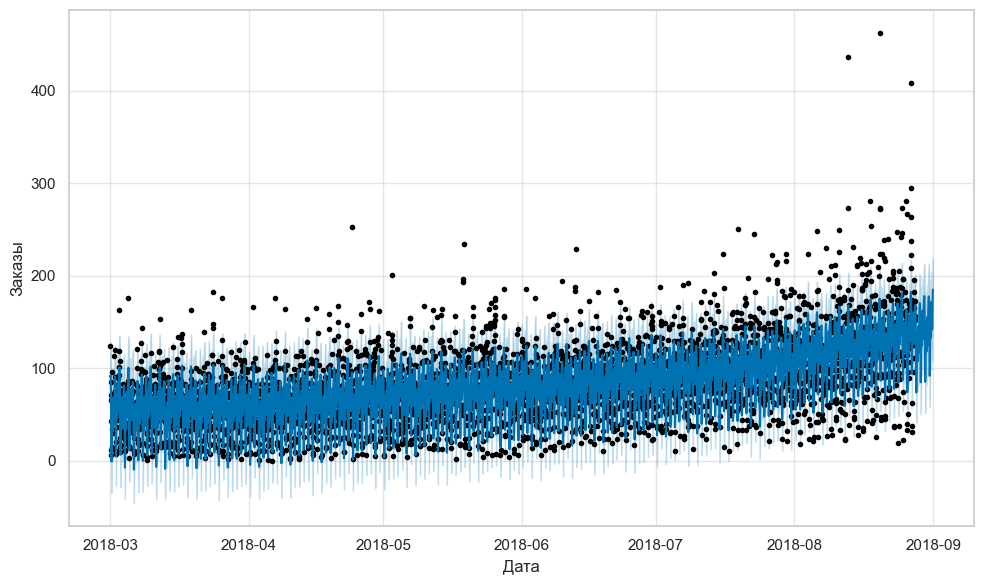

In [27]:
m.plot(forecast)
plt.xlabel('Дата')
plt.ylabel('Заказы');

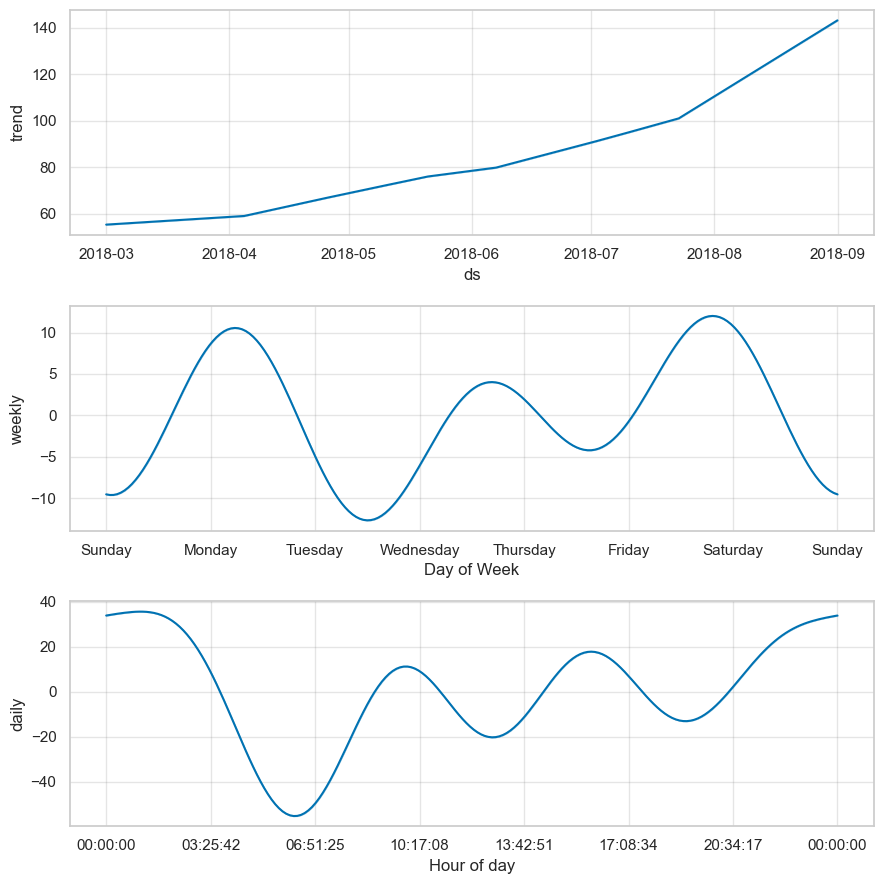

In [28]:
m.plot_components(forecast);

**Посмотрим на интерактивный график прогноза заказов**

In [29]:
cmp_df = forecast.set_index('ds')[['yhat', 'trend','additive_terms', 'yhat_lower', 'yhat_upper', 'trend_lower',
                                   'trend_upper',  'additive_terms', 'additive_terms_lower',
                                   'additive_terms_upper', 'daily', 'weekly']].join(taxi)

In [30]:
#функция для визуализации построенного прогноза
def show_forecast(df, num_predictions, num_values):
    #верхняя граница доверительного интервала прогноза
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=df.tail(num_predictions).index,
        y=df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    #прогноз
    forecast = go.Scatter(
        name='Prediction',
        x=df.tail(predictions).index,
        y=df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    #нижняя граница доверительного интервала
    lower_bound = go.Scatter(
        name='Lower Bound',
        x=df.tail(num_predictions).index,
        y=df.tail(num_predictions).yhat_lower,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines')

    #фактические значения
    fact = go.Scatter(
        name='Fact',
        x=df.tail(num_values).index,
        y=df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    #последовательность рядов в данном случае важна из-за применения заливки
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='Количество заказов'),
        title='Заказы такси: прогноз',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(round(cmp_df), predictions, 200)
show()

**Мы можем наблюдать что переломные пики предсказать очень трудно**

In [31]:
cmp_df.isna().sum()

yhat                    0
trend                   0
additive_terms          0
yhat_lower              0
yhat_upper              0
trend_lower             0
trend_upper             0
additive_terms          0
additive_terms_lower    0
additive_terms_upper    0
daily                   0
weekly                  0
y                       0
dtype: int64

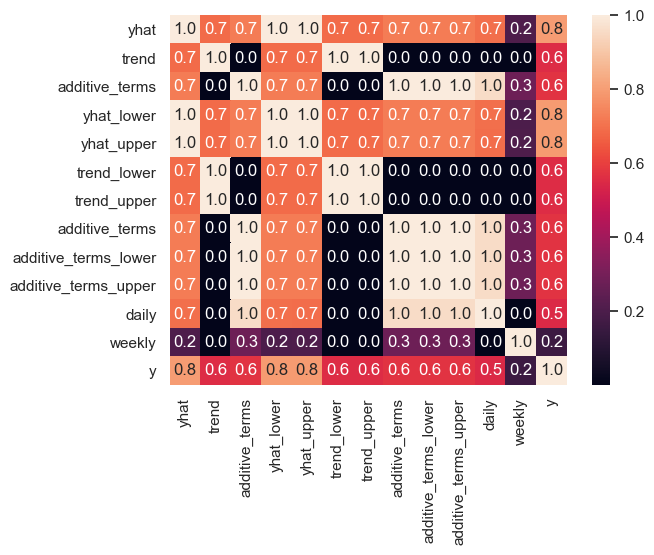

In [32]:
sns.heatmap(data=cmp_df.corr(), annot=True, fmt='.1f');

# Обучение

In [33]:
train, test = train_test_split(cmp_df, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
train = train.dropna()
test = test.dropna()
X_train = train.drop(['y'], axis=1)
X_test = test.drop(['y'], axis=1)
y_train = train['y']
y_test = test['y']
print(f"  Train: size={train.shape[0]}")
print(f"  Test:  size={test.shape[0]}")

  Train: size=3974
  Test:  size=442


In [34]:
X_train

yhat  trend  additive_terms  yhat_lower  yhat_upper  trend_lower  trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  daily  weekly
ds                                                                                                                                                                            
2018-03-01 00:00:00  91.07  55.22           35.85       55.97      127.91        55.22        55.22           35.85                 35.85                 35.85  33.91    1.94
2018-03-01 01:00:00  92.26  55.22           37.04       59.00      124.98        55.22        55.22           37.04                 37.04                 37.04  35.61    1.43
2018-03-01 02:00:00  89.06  55.23           33.84       53.94      122.05        55.23        55.23           33.84                 33.84                 33.84  32.95    0.89
2018-03-01 03:00:00  74.58  55.23           19.35       40.27      107.66        55.23        55.23           19.35                 19.35                 19.35  19.02    0.33
2018-03-01 04:00:00  47.02  55.24           -8.22       13.90       83.18        55.24        55.24           -8.22                 -8.22                 -8.22  -7.98   -0.24
2018-03-01 05:00:00  16.22  55.24          -39.02      -16.12       51.10        55.24        55.24          -39.02                -39.02                -39.02 -38.21   -0.81
2018-03-01 06:00:00  -0.89  55.25          -56.14      -35.19       35.67        55.25        55.25          -56.14                -56.14                -56.14 -54.78   -1.36
2018-03-01 07:00:00   6.21  55.25          -49.04      -26.70       42.11        55.25        55.25          -49.04                -49.04                -49.04 -47.15   -1.89
2018-03-01 08:00:00  31.56  55.25          -23.70       -2.72       65.66        55.25        55.25          -23.70                -23.70                -23.70 -21.31   -2.39
2018-03-01 09:00:00  56.11  55.26            0.85       21.96       89.88        55.26        55.26            0.85                  0.85                  0.85   3.69   -2.84
2018-03-01 10:00:00  62.98  55.26            7.72       29.75       94.78        55.26        55.26            7.72                  7.72                  7.72  10.96   -3.24
2018-03-01 11:00:00  51.15  55.27           -4.11       17.71       85.86        55.27        55.27           -4.11                 -4.11                 -4.11  -0.53   -3.59
2018-03-01 12:00:00  35.27  55.27          -20.00        0.23       68.47        55.27        55.27          -20.00                -20.00                -20.00 -16.14   -3.86
2018-03-01 13:00:00  31.87  55.28          -23.40       -0.60       66.06        55.28        55.28          -23.40                -23.40                -23.40 -19.34   -4.07
2018-03-01 14:00:00  44.63  55.28          -10.65       11.10       77.74        55.28        55.28          -10.65                -10.65                -10.65  -6.46   -4.19
2018-03-01 15:00:00  62.04  55.28            6.76       28.75       94.79        55.28        55.28            6.76                  6.76                  6.76  10.99   -4.23
2018-03-01 16:00:00  68.89  55.29           13.60       34.01      100.45        55.29        55.29           13.60                 13.60                 13.60  17.79   -4.19
2018-03-01 17:00:00  60.35  55.29            5.06       24.61       95.05        55.29        55.29            5.06                  5.06                  5.06   9.11   -4.06
2018-03-01 18:00:00  45.63  55.30           -9.67       11.36       80.91        55.30        55.30           -9.67                 -9.67                 -9.67  -5.83   -3.84
2018-03-01 19:00:00  38.72  55.30          -16.58        3.49       71.04        55.30        55.30          -16.58                -16.58                -16.58 -13.05   -3.53
2018-03-01 20:00:00  45.90  55.31           -9.40       12.46       78.53        55.31        55.31           -9.40                 -9.40                 -9.40  -6.27   -3.

In [35]:
X_test

yhat  trend  additive_terms  yhat_lower  yhat_upper  trend_lower  trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  daily  weekly
ds                                                                                                                                                                            
2018-08-13 14:00:00 123.62 123.67           -0.04       90.42      159.74       123.67       123.67           -0.04                 -0.04                 -0.04  -6.46    6.41
2018-08-13 15:00:00 140.14 123.71           16.43      105.98      175.64       123.71       123.71           16.43                 16.43                 16.43  10.99    5.44
2018-08-13 16:00:00 145.95 123.75           22.19      109.72      182.10       123.75       123.75           22.19                 22.19                 22.19  17.79    4.41
2018-08-13 17:00:00 136.22 123.80           12.42      103.24      168.26       123.80       123.80           12.42                 12.42                 12.42   9.11    3.31
2018-08-13 18:00:00 120.18 123.84           -3.66       85.66      153.53       123.84       123.84           -3.66                 -3.66                 -3.66  -5.83    2.17
2018-08-13 19:00:00 111.83 123.89          -12.06       80.20      144.96       123.89       123.89          -12.06                -12.06                -12.06 -13.05    0.99
2018-08-13 20:00:00 117.45 123.93           -6.48       86.22      154.37       123.93       123.93           -6.48                 -6.48                 -6.48  -6.27   -0.21
2018-08-13 21:00:00 131.70 123.97            7.73       95.59      167.61       123.97       123.97            7.73                  7.73                  7.73   9.14   -1.41
2018-08-13 22:00:00 144.56 124.02           20.54      110.93      176.41       124.02       124.02           20.54                 20.54                 20.54  23.15   -2.61
2018-08-13 23:00:00 150.98 124.06           26.92      116.22      182.73       124.06       124.06           26.92                 26.92                 26.92  30.71   -3.80
2018-08-14 00:00:00 153.06 124.11           28.96      121.73      188.64       124.11       124.11           28.96                 28.96                 28.96  33.91   -4.95
2018-08-14 01:00:00 153.70 124.15           29.55      117.13      188.96       124.15       124.15           29.55                 29.55                 29.55  35.61   -6.06
2018-08-14 02:00:00 150.03 124.19           25.84      115.23      185.49       124.19       124.19           25.84                 25.84                 25.84  32.95   -7.11
2018-08-14 03:00:00 135.16 124.24           10.92      103.00      168.82       124.24       124.24           10.92                 10.92                 10.92  19.02   -8.10
2018-08-14 04:00:00 107.29 124.28          -16.99       73.55      139.53       124.28       124.28          -16.99                -16.99                -16.99  -7.98   -9.01
2018-08-14 05:00:00  76.28 124.33          -48.05       45.33      109.58       124.33       124.33          -48.05                -48.05                -48.05 -38.21   -9.84
2018-08-14 06:00:00  59.02 124.37          -65.35       26.08       91.16       124.37       124.37          -65.35                -65.35                -65.35 -54.78  -10.57
2018-08-14 07:00:00  66.06 124.41          -58.35       30.87      100.70       124.41       124.41          -58.35                -58.35                -58.35 -47.15  -11.20
2018-08-14 08:00:00  91.42 124.46          -33.04       56.41      123.09       124.46       124.46          -33.04                -33.04                -33.04 -21.31  -11.73
2018-08-14 09:00:00 116.05 124.50           -8.45       81.88      150.58       124.50       124.50           -8.45                 -8.45                 -8.45   3.69  -12.14
2018-08-14 10:00:00 123.07 124.55           -1.48       87.41      157.06       124.55       124.55           -1.48                 -1.48                 -1.48  10.96  -12.

In [36]:
pipeline = Pipeline(steps=[('scaler', RobustScaler())])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [37]:
split = TimeSeriesSplit(n_splits=3)

In [38]:
#функция для кросс валидации (подбора модели без гиперпараметров)
def cross_val(model):
    cvs = cross_val_score(model, X_train, y_train, cv=split,
                          scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
    return print("Лучшее значение",  model,  "на кросс валидации:", -cvs)

In [39]:
cross_val(Lasso(random_state=RANDOM_STATE))

Лучшее значение Lasso(random_state=42) на кросс валидации: 27.017146640288928


In [40]:
cross_val(ElasticNet(random_state=RANDOM_STATE))

Лучшее значение ElasticNet(random_state=42) на кросс валидации: 28.884780609752664


In [41]:
cross_val(Ridge(random_state=RANDOM_STATE))

Лучшее значение Ridge(random_state=42) на кросс валидации: 25.918358192186503


In [42]:
cross_val(LGBMRegressor(random_state=RANDOM_STATE))

Лучшее значение LGBMRegressor(random_state=42) на кросс валидации: 25.43911244557414


In [43]:
cross_val(CatBoostRegressor(random_state=RANDOM_STATE))

Лучшее значение <catboost.core.CatBoostRegressor object at 0x000001E9266AAB20> на кросс валидации: 25.547360866020142


**По итогам кросс валидации у нас лидируют Ridge, LGBM и CatBoost**

In [44]:
%%time
rg = Pipeline(steps=[('regressor', Ridge(random_state=RANDOM_STATE))])


#задаем параметры для grid search
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1]
}

#создаем объект GridSearchCV
s_rg = GridSearchCV(rg, param_grid=param_grid, cv=split,
                      scoring='neg_root_mean_squared_error',
                      refit=True, error_score='raise', n_jobs=-1)

#обучаем модель на тренировочных данных
s_rg.fit(X_train, y_train)

#выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_rg.best_params_)
print("Лучшее значение: ", -s_rg.best_score_)

Лучшие параметры:  {'regressor__alpha': 0.1}
Лучшее значение:  25.911112415758907
CPU times: total: 46.9 ms
Wall time: 65.5 ms


In [45]:
%%time
lgbm = Pipeline(steps=[('regressor', LGBMRegressor(random_state=RANDOM_STATE))])


#задаем параметры для grid search
param_grid = {
    'regressor__learning_rate': [0.1, 0.2],
    'regressor__n_estimators' : range(100, 400, 50),
    'regressor__max_depth' : range(10, 16 , 5),
}

#создаем объект GridSearchCV
s_lgbm = GridSearchCV(lgbm, param_grid=param_grid, cv=split,
                      scoring='neg_root_mean_squared_error',
                      refit=True, error_score='raise', n_jobs=-1)

#обучаем модель на тренировочных данных
s_lgbm.fit(X_train, y_train)

#выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_lgbm.best_params_)
print("Лучшее значение: ", -s_lgbm.best_score_)

Лучшие параметры:  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 150}
Лучшее значение:  25.442973620900364
CPU times: total: 1.53 s
Wall time: 7.42 s


In [46]:
%%time
cb = Pipeline(steps=[('regressor', CatBoostRegressor(random_state=RANDOM_STATE))])
param_grid = {
    'regressor__learning_rate': [0.1, 0.3, 0.01],
    'regressor__n_estimators': range(100, 301, 100),
}

#создаем объект GridSearchCV
s_cb = GridSearchCV(cb, param_grid=param_grid, cv=split,
                    scoring='neg_root_mean_squared_error', refit=True, error_score='raise', n_jobs=-1)

#обучаем модель на тренировочных данных
s_cb.fit(X_train, y_train)

#выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_cb.best_params_)
print("Лучшее значение: ", -s_cb.best_score_)

0:	learn: 36.5910381	total: 146ms	remaining: 29s
1:	learn: 34.8371920	total: 149ms	remaining: 14.7s
2:	learn: 33.2073988	total: 151ms	remaining: 9.94s
3:	learn: 31.7997671	total: 154ms	remaining: 7.54s
4:	learn: 30.6626806	total: 156ms	remaining: 6.1s
5:	learn: 29.6059288	total: 159ms	remaining: 5.15s
6:	learn: 28.6640210	total: 162ms	remaining: 4.47s
7:	learn: 27.8691235	total: 165ms	remaining: 3.95s
8:	learn: 27.2046515	total: 168ms	remaining: 3.56s
9:	learn: 26.6505503	total: 170ms	remaining: 3.24s
10:	learn: 26.2300910	total: 173ms	remaining: 2.98s
11:	learn: 25.8353892	total: 176ms	remaining: 2.76s
12:	learn: 25.4810685	total: 179ms	remaining: 2.57s
13:	learn: 25.0785038	total: 182ms	remaining: 2.41s
14:	learn: 24.7940129	total: 185ms	remaining: 2.27s
15:	learn: 24.5677840	total: 187ms	remaining: 2.15s
16:	learn: 24.2594552	total: 190ms	remaining: 2.05s
17:	learn: 24.0906496	total: 193ms	remaining: 1.95s
18:	learn: 23.9497131	total: 196ms	remaining: 1.86s
19:	learn: 23.6931691	tot

199:	learn: 17.6011018	total: 727ms	remaining: 0us
Лучшие параметры:  {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 200}
Лучшее значение:  25.38614899797353
CPU times: total: 4.64 s
Wall time: 11.5 s


**Так как все три модели показывают впринципе неплохой результат, я склоняюсь сделать bagging для двух моделей-Ridge(линейная) так как мы знаем, что линейные модели хорошо экстраполируют, чтобы строить прогноз не только на ближайший час, а видеть тренды, по месяцам..., и CatBoost так как у этой модели вшиты хорошие параметры для предотвращения переобучения**

In [47]:
#создаем базовые модели
catboost = s_cb.best_estimator_
ridge = s_rg.best_estimator_

#создаем бэггинг-модель, используя базовые модели
bagging = BaggingRegressor(base_estimator=catboost, n_estimators=6, random_state=RANDOM_STATE)

pipeline = Pipeline([('bagging', bagging)
])


param_grid = { }

#создаем объект GridSearchCV
search_bagging = GridSearchCV(pipeline, param_grid=param_grid, cv=split,
                              scoring='neg_root_mean_squared_error', n_jobs=-1, refit=True)

#обучаем модель на тренировочных данных
search_bagging.fit(X_train, y_train)

#выводим результаты кросс-валидации
print("Best cross-validation score: ", -search_bagging.best_score_)


0:	learn: 36.7106093	total: 3.72ms	remaining: 740ms
1:	learn: 34.8800153	total: 7.5ms	remaining: 743ms
2:	learn: 33.2092682	total: 11.2ms	remaining: 736ms
3:	learn: 31.8110442	total: 15ms	remaining: 735ms
4:	learn: 30.5620520	total: 19.1ms	remaining: 743ms
5:	learn: 29.5221844	total: 22.7ms	remaining: 734ms
6:	learn: 28.5864289	total: 26.5ms	remaining: 732ms
7:	learn: 27.8311538	total: 30ms	remaining: 719ms
8:	learn: 27.1560850	total: 33.4ms	remaining: 708ms
9:	learn: 26.5435700	total: 37.3ms	remaining: 709ms
10:	learn: 26.0443365	total: 41.1ms	remaining: 707ms
11:	learn: 25.5828196	total: 44.5ms	remaining: 697ms
12:	learn: 25.1949054	total: 47.9ms	remaining: 689ms
13:	learn: 24.8711345	total: 51.4ms	remaining: 683ms
14:	learn: 24.5634020	total: 54.6ms	remaining: 673ms
15:	learn: 24.3174732	total: 58.3ms	remaining: 670ms
16:	learn: 24.0623432	total: 61.7ms	remaining: 664ms
17:	learn: 23.8524555	total: 65.6ms	remaining: 663ms
18:	learn: 23.6232685	total: 69.1ms	remaining: 658ms
19:	lear

1:	learn: 35.3395001	total: 7.6ms	remaining: 753ms
2:	learn: 33.7341852	total: 11.2ms	remaining: 736ms
3:	learn: 32.3358899	total: 14.7ms	remaining: 718ms
4:	learn: 31.1327675	total: 18ms	remaining: 703ms
5:	learn: 30.1223316	total: 21.4ms	remaining: 692ms
6:	learn: 29.2068545	total: 25.2ms	remaining: 696ms
7:	learn: 28.4212337	total: 28.9ms	remaining: 694ms
8:	learn: 27.7765754	total: 32.2ms	remaining: 682ms
9:	learn: 27.2683216	total: 35.5ms	remaining: 675ms
10:	learn: 26.7927750	total: 51.3ms	remaining: 881ms
11:	learn: 26.3284993	total: 61.9ms	remaining: 969ms
12:	learn: 25.9674882	total: 71.4ms	remaining: 1.03s
13:	learn: 25.6107476	total: 77.7ms	remaining: 1.03s
14:	learn: 25.3035255	total: 80.9ms	remaining: 998ms
15:	learn: 25.0438970	total: 87.2ms	remaining: 1s
16:	learn: 24.8393461	total: 90.7ms	remaining: 977ms
17:	learn: 24.6611316	total: 94.5ms	remaining: 956ms
18:	learn: 24.3534531	total: 98.3ms	remaining: 936ms
19:	learn: 24.2206560	total: 102ms	remaining: 921ms
20:	learn

163:	learn: 17.3274353	total: 592ms	remaining: 130ms
164:	learn: 17.2893316	total: 595ms	remaining: 126ms
165:	learn: 17.2621216	total: 599ms	remaining: 123ms
166:	learn: 17.2444999	total: 602ms	remaining: 119ms
167:	learn: 17.2223927	total: 605ms	remaining: 115ms
168:	learn: 17.1940536	total: 609ms	remaining: 112ms
169:	learn: 17.1670551	total: 613ms	remaining: 108ms
170:	learn: 17.1432042	total: 616ms	remaining: 105ms
171:	learn: 17.1189744	total: 620ms	remaining: 101ms
172:	learn: 17.0844839	total: 623ms	remaining: 97.2ms
173:	learn: 17.0552193	total: 626ms	remaining: 93.6ms
174:	learn: 17.0326165	total: 629ms	remaining: 89.9ms
175:	learn: 17.0131722	total: 632ms	remaining: 86.2ms
176:	learn: 16.9926969	total: 635ms	remaining: 82.6ms
177:	learn: 16.9721655	total: 638ms	remaining: 78.9ms
178:	learn: 16.9534672	total: 641ms	remaining: 75.2ms
179:	learn: 16.9240181	total: 644ms	remaining: 71.6ms
180:	learn: 16.9041565	total: 648ms	remaining: 68ms
181:	learn: 16.8835026	total: 651ms	rem

139:	learn: 17.8863907	total: 447ms	remaining: 192ms
140:	learn: 17.8484742	total: 451ms	remaining: 189ms
141:	learn: 17.8309736	total: 455ms	remaining: 186ms
142:	learn: 17.7959851	total: 458ms	remaining: 183ms
143:	learn: 17.7703540	total: 461ms	remaining: 179ms
144:	learn: 17.7277618	total: 465ms	remaining: 176ms
145:	learn: 17.7122427	total: 468ms	remaining: 173ms
146:	learn: 17.6802397	total: 471ms	remaining: 170ms
147:	learn: 17.6602065	total: 475ms	remaining: 167ms
148:	learn: 17.6448284	total: 478ms	remaining: 164ms
149:	learn: 17.6317467	total: 481ms	remaining: 160ms
150:	learn: 17.5894039	total: 485ms	remaining: 157ms
151:	learn: 17.5561583	total: 488ms	remaining: 154ms
152:	learn: 17.5349196	total: 491ms	remaining: 151ms
153:	learn: 17.5017267	total: 494ms	remaining: 148ms
154:	learn: 17.4606674	total: 497ms	remaining: 144ms
155:	learn: 17.4444517	total: 500ms	remaining: 141ms
156:	learn: 17.4136088	total: 503ms	remaining: 138ms
157:	learn: 17.3923416	total: 506ms	remaining:

101:	learn: 18.4736415	total: 352ms	remaining: 338ms
102:	learn: 18.4465917	total: 355ms	remaining: 334ms
103:	learn: 18.4259651	total: 358ms	remaining: 331ms
104:	learn: 18.3905434	total: 361ms	remaining: 327ms
105:	learn: 18.3753310	total: 364ms	remaining: 323ms
106:	learn: 18.3552875	total: 368ms	remaining: 320ms
107:	learn: 18.3222164	total: 371ms	remaining: 316ms
108:	learn: 18.2675565	total: 374ms	remaining: 312ms
109:	learn: 18.2127737	total: 377ms	remaining: 309ms
110:	learn: 18.1588713	total: 381ms	remaining: 305ms
111:	learn: 18.1444364	total: 384ms	remaining: 301ms
112:	learn: 18.1280773	total: 387ms	remaining: 298ms
113:	learn: 18.1000330	total: 390ms	remaining: 294ms
114:	learn: 18.0588467	total: 393ms	remaining: 290ms
115:	learn: 18.0282679	total: 396ms	remaining: 287ms
116:	learn: 18.0027158	total: 400ms	remaining: 284ms
117:	learn: 17.9767774	total: 403ms	remaining: 280ms
118:	learn: 17.9429516	total: 406ms	remaining: 276ms
119:	learn: 17.9041732	total: 409ms	remaining:

71:	learn: 20.7369854	total: 242ms	remaining: 430ms
72:	learn: 20.6901014	total: 246ms	remaining: 427ms
73:	learn: 20.6638796	total: 249ms	remaining: 424ms
74:	learn: 20.6307211	total: 252ms	remaining: 420ms
75:	learn: 20.5931024	total: 256ms	remaining: 417ms
76:	learn: 20.5654597	total: 260ms	remaining: 415ms
77:	learn: 20.5336514	total: 263ms	remaining: 411ms
78:	learn: 20.4988596	total: 266ms	remaining: 408ms
79:	learn: 20.4829544	total: 270ms	remaining: 406ms
80:	learn: 20.4105701	total: 276ms	remaining: 405ms
81:	learn: 20.3935070	total: 279ms	remaining: 402ms
82:	learn: 20.3367762	total: 283ms	remaining: 399ms
83:	learn: 20.2719306	total: 288ms	remaining: 398ms
84:	learn: 20.2128422	total: 292ms	remaining: 395ms
85:	learn: 20.1571769	total: 295ms	remaining: 392ms
86:	learn: 20.1226963	total: 299ms	remaining: 388ms
87:	learn: 20.0859600	total: 303ms	remaining: 386ms
88:	learn: 20.0392379	total: 307ms	remaining: 383ms
89:	learn: 20.0037133	total: 310ms	remaining: 379ms
90:	learn: 1

47:	learn: 21.1301284	total: 149ms	remaining: 470ms
48:	learn: 21.0364204	total: 152ms	remaining: 469ms
49:	learn: 20.9590374	total: 156ms	remaining: 467ms
50:	learn: 20.9150005	total: 159ms	remaining: 464ms
51:	learn: 20.8686454	total: 163ms	remaining: 463ms
52:	learn: 20.8356775	total: 166ms	remaining: 461ms
53:	learn: 20.7959110	total: 170ms	remaining: 460ms
54:	learn: 20.7212710	total: 173ms	remaining: 457ms
55:	learn: 20.7020344	total: 176ms	remaining: 454ms
56:	learn: 20.6318126	total: 180ms	remaining: 450ms
57:	learn: 20.6121642	total: 183ms	remaining: 448ms
58:	learn: 20.5883179	total: 186ms	remaining: 444ms
59:	learn: 20.5324935	total: 189ms	remaining: 442ms
60:	learn: 20.4866874	total: 193ms	remaining: 439ms
61:	learn: 20.4391218	total: 196ms	remaining: 436ms
62:	learn: 20.4057482	total: 199ms	remaining: 433ms
63:	learn: 20.3772193	total: 202ms	remaining: 429ms
64:	learn: 20.3204335	total: 205ms	remaining: 426ms
65:	learn: 20.2749309	total: 208ms	remaining: 423ms
66:	learn: 2

# Тестирование

**Константная модель**

In [48]:
dummy = Pipeline(steps=[('regressor',DummyRegressor(strategy="mean"))
])

dummy.fit(X_train, y_train)

test_model = dummy.predict(X_test)

RMSE = mean_squared_error(y_test, test_model, squared=False)

print('RMSE DummyRegressor равен:', round(RMSE, 2))


RMSE DummyRegressor равен: 84.74


In [49]:
%%time
bg = search_bagging.best_estimator_.predict(X_test)
RMSE = sqrt(mean_squared_error(y_test, bg))
print('RMSE Bagging тест равен:', round(RMSE, 2))

RMSE Bagging тест равен: 36.61
CPU times: total: 62.5 ms
Wall time: 16.6 ms


**Интерактивный график предсказания лучшей модели и факта**

In [50]:
x = y_test.values
y = bg.astype(int)
data = pd.DataFrame({'true': x, 'predict': y}).set_index(y_test.index)
plotly_df(data, title='Сравнение предсказания и факта')
show()

# Вывод:

Модель победитель **CatBoost & Ridge** (**Bagging Regressor**) 
- **RMSE обучающей выборки: 24.78**
- **RMSE тестовой выборки: 36.40**

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48